## 死亡情報以外の疑似生成

**加入者情報テーブル**
- 個人ID
- 性別
- 従業員/家族
- 誕生年月
- 観察開始年月
- 観察終了年月
- 観察終了事由(死亡)

In [2]:
%matplotlib notebook
%matplotlib inline
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 表示する行の数を設定
pd.options.display.max_rows = 10
# 表示する列の数を設定
pd.options.display.max_columns = 12
# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
def ym_to_t(ym):
    """
    ymの月の月央をスカラーに変換する。
    
    Args:
        ym (DateTime): DateTime型の日付
    
    Returns:
        float: スカラー型の日付
        
    Example:
        >>> ym_to_t("2010/06")
        2010.4583333333333
    """
    y = int(ym[:4])
    m = int(ym[5:])
    return y + m

In [4]:
def t_to_ym(t):
    """
    スカラーtをymに変換する。

    """
    y = int(t)
    m = int((t - y) * 12) + 1
    m = max(min(m, 12), 1)
    # 月部分を2桁表示になるよう、つまり
    # "2010/1" でなく "2010/01" となるよう
    # zfill(2) でパディングする。
    return str(y) + '/' + str(m).zfill(2)

In [5]:
df_birth = pd.read_csv('./ipss_birth.csv')

In [6]:
df_birth.head()

,year,sex,ratio,cum_ratio
0,1947,f,0.012150,0.012150
1,1948,f,0.012162,0.024311
2,1949,f,0.012288,0.036600
3,1950,f,0.010587,0.047187
4,1951,f,0.009735,0.056922


In [7]:
start_study_t = 2010 # 分析開始時点 (2010年1月)
end_study_t = 2019.999 # 分析終了時点 (2019年12月)
# 指数分布のパラメタ
# 観察開始期間、観察終了期間を決定する。
mu = 10
N = 5000 # N 人の加入者を生成する。
family_ratio = 0.3 # 全体の内、扶養家族の占める割合

In [12]:
 df_birth[df_birth["cum_ratio"] > np.random.rand()].iloc[0]

year              1947
sex                  m
ratio        0.0128516
cum_ratio     0.498796
Name: 70, dtype: object

In [31]:
i = 0
rs = 0
np.random.seed(rs)
random_nums = np.random.rand(10)
df_info = pd.DataFrame()

while len(df_info) < N:
    ss = df_birth[df_birth["cum_ratio"] > np.random.rand()].iloc[0]
    rs += 1
    np.random.seed(rs)
    sex = ss.sex
    by = ss.year
    bt = by + np.random.rand()
    rs += 1
    np.random.seed(rs)
    bym = t_to_ym(bt)
    # なぜ - mu なのか。
    start_t = start_study_t - mu + np.random.exponential(mu)
    rs += 1
    np.random.seed(rs)
    end_t = start_t + np.random.exponential(mu)
    rs += 1
    np.random.seed(rs)
    if (start_t > end_study_t) | (end_t < start_study_t):
        pass
    else:
        # iid: 加入者ID
        cols = ['iid', 'sex', 'family', 'birth_ym',
                'start_obs_ym', 'end_obs_ym']
        df_exposure = pd.DataFrame(np.zeros(len(cols)).reshape(1, len(cols)),
                                   columns=cols)
        # 本人: 1, 家族: 2
        family = 2 - (np.random.rand() > family_ratio)
        rs += 1
        np.random.seed(rs)
        df_exposure[cols] = [
            'i' + str(i).zfill(6), sex, family, bym,
            t_to_ym(start_t), t_to_ym(end_t)
        ]
        df_info = pd.concat([df_info, df_exposure], axis=0)
    i += 1
df_info = df_info.reset_index()
del df_info['index']


In [33]:
df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym
0,i000000,m,1.0,1980/06,2005/09,2013/09
1,i000001,f,2.0,1972/11,2000/10,2021/06
2,i000002,m,1.0,1978/03,2001/09,2016/09
3,i000003,m,2.0,1989/03,2003/06,2013/12
4,i000006,m,1.0,1973/11,2010/04,2013/09
...,...,...,...,...,...,...
4995,i008255,m,1.0,1988/12,2003/05,2013/07
4996,i008259,m,1.0,2012/11,2004/10,2015/02
4997,i008260,m,1.0,1987/02,2019/06,2026/01
4998,i008263,m,1.0,1980/08,2007/09,2016/11


In [61]:
df_birth_M = df_birth.loc[df_birth.sex == 'm', ['year', 'ratio']]
df_birth_M['ratio'] = df_birth_M.ratio / df_birth_M.ratio.sum()
df_info_M = df_info.loc[df_info.sex == 'm', ['birth_ym', 'family']]
df_info_M['birth_ym'] = df_info_M.birth_ym.apply(ym_to_t) // 1
df_info_M = df_info_M.groupby(['birth_ym']).count()
df_info_M = df_info_M / df_info_M.sum()

In [62]:
df_info_M

,family
birth_ym,
1948,0.001162
1949,0.004648
1950,0.005809
1951,0.009295
1952,0.012393
...,...
2024,0.003486
2025,0.003098
2026,0.003486


Text(0.5, 1.0, 'Birth Ratio (M)')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


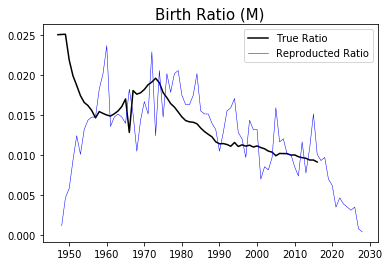

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_birth_M.year, df_birth_M.ratio, c='k', label='True Ratio')
ax.plot(df_info_M.index, df_info_M.family, c='b',
label='Reproducted Ratio', lw=0.5)
ax.legend(loc='best')
ax.set_title('Birth Ratio (M)', fontsize=15)